In [215]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const
import data.scripts.gen_tables.gen_pair_configs as gen_pair
import data.scripts.predict.predict_slowdown as predict

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Pair - dynamic

In [213]:
gen_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_pair.py')
baseline = 'seq'
seq_pkl = os.path.join(PKL_PATH, 'seq.pkl')
intra_pkl = os.path.join(PKL_PATH, 'intra.pkl')
csv = os.path.join(HOME, 'data/csv/pair_dynamic.csv')
output = os.path.join(PKL_PATH, 'pair_dynamic_seq.pkl')

%run $gen_pair --csv $csv --output $output --seq_pkl $seq_pkl --intra_pkl $intra_pkl 

In [214]:
df_dynamic = pd.read_pickle(output)
df_dynamic.sort_values(['1_bench', '2_bench'], inplace=True)
df_dynamic.reset_index(inplace=True, drop=True)
print(df_dynamic.shape)

# FIXME: drop any rows with zero fairness
df_dynamic = df_dynamic[df_dynamic['fairness'] > 0]
print(df_dynamic.shape)


(318, 211)
(313, 211)


# Prediction Model

In [224]:
X, y = predict.prepare_datasets(df_dynamic)
model = predict.train(X, y)

X invalid? False
X invalid? False
(626, 6) (626,)
K-fold l1 error: 0.07249461238807875
K-fold l1 error: 0.07881065116074705
K-fold l1 error: 0.06812729341878279
K-fold l1 error: 0.06704203033387965
K-fold l1 error: 0.06304336109131738


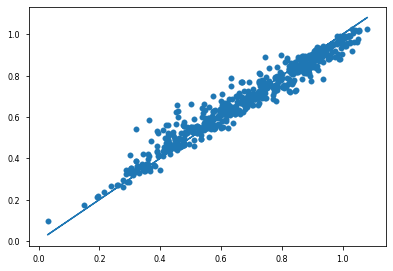

In [225]:
plt.scatter(y, model.predict(X))
plt.plot(y, y)
plt.show()

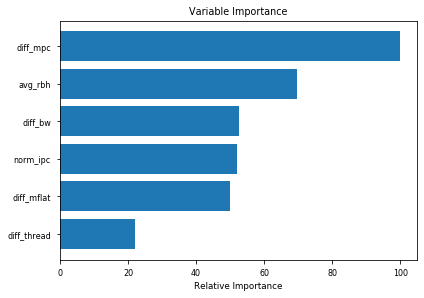

In [226]:
predict.plot_importance(model)

In [227]:
df_dynamic['1_predicted'] = predict.predict_from_df(model, df_dynamic, 'x')
df_dynamic['2_predicted'] = predict.predict_from_df(model, df_dynamic, 'y')

df_dynamic['1_delta'] = df_dynamic['1_predicted'] - df_dynamic['1_sld']
df_dynamic['2_delta'] = df_dynamic['2_predicted'] - df_dynamic['2_sld']

In [229]:
# Only show best performance for each benchmark pair
# df_dynamic_show = df_dynamic.sort_values('ws', ascending=False).drop_duplicates(['1_bench','2_bench'])
# df_dynamic_show.reset_index(inplace=True, drop=True)

col_dynamic_seq = ['1_bench', 'intra_x', 'l2_x',
                   '2_bench', 'intra_y', 'l2_y',
                   # '1_intra', '2_intra', '1_l2', '2_l2', 
#                    'norm_ipc_x', 
                   '1_sld', '1_predicted', # '1_infer', 
                   '1_delta',
#                    'norm_ipc_y', 
                   '2_sld', '2_predicted', # '2_infer', 
                   '2_delta',
#                    'ws', 'fairness', 
#                    'sum_ipc', 'diff_mflat', 'sum_dram',
#                    '1_norm_mflat', '2_norm_mflat'
                  ]
def highlight_error(s):
    is_high = np.abs(s) > 0.1
    return ['background-color: yellow' if v else '' for v in is_high]

draw_table(df_dynamic, 
           col_dynamic_seq, False).apply(highlight_error, subset=['1_delta', '2_delta'])

,1_bench,intra_x,l2_x,2_bench,intra_y,l2_y,1_sld,1_predicted,1_delta,2_sld,2_predicted,2_delta
0,cut_sgemm-1,1,0.25,cut_wmma-0,2,0.75,0.983571,0.904747,-0.0788245,0.808275,0.740042,-0.0682332
1,cut_sgemm-1,1,0.5,parb_cutcp-0,2,0.5,0.916346,0.931532,0.0151866,0.858277,0.851891,-0.0063865
2,cut_sgemm-1,1,0.25,parb_cutcp-0,2,0.75,0.916238,0.938691,0.022453,0.858958,0.851891,-0.00706732
3,cut_sgemm-1,1,0.75,parb_cutcp-0,2,0.25,0.921009,0.931532,0.0105236,0.857086,0.85199,-0.00509655
4,cut_sgemm-1,1,0.75,parb_lbm-0,3,0.25,0.874346,0.81911,-0.0552356,0.783475,0.796775,0.0133001
5,cut_sgemm-1,1,0.25,parb_lbm-0,6,0.75,0.443625,0.465461,0.0218362,0.846681,0.818996,-0.0276848
6,cut_sgemm-1,1,0.25,parb_lbm-0,3,0.75,0.835048,0.761293,-0.0737553,0.779495,0.79074,0.0112449
7,cut_sgemm-1,1,0.5,parb_spmv-0,6,0.5,0.962401,0.891552,-0.070849,0.86801,0.856419,-0.0115913
8,cut_sgemm-1,1,0.25,parb_spmv-0,6,0.75,0.955459,0.88734,-0.0681193,0.875704,0.860069,-0.0156352
9,cut_sgemm-1,1,0.75,parb_spmv-0,6,0.25,0.973556,0.891552,-0.0820037,0.770327,0.741444,-0.028883
